In [1]:
#https://github.com/miguelfzafra/Latest-News-Classifier/blob/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training/11.%20MT%20-%20GBM.ipynb
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pathPickle = "Pickles"
path_df = pathPickle+"/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

    
# features_train
path_features_train = pathPickle+"/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = pathPickle+"/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = pathPickle+"/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = pathPickle+"/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [2]:
gb_0 = GradientBoostingClassifier(random_state = 8)

print('Parameters currently in use:\n')
pprint(gb_0.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 8,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [3]:
n_estimators = [200, 800]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [10, 40]
max_depth.append(None)

# min_samples_split
min_samples_split = [10, 30, 50]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# learning rate
learning_rate = [.1, .5]

# subsample
subsample = [.5, 1.]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate,
               'subsample': subsample}

pprint(random_grid)

{'learning_rate': [0.1, 0.5],
 'max_depth': [10, 40, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [10, 30, 50],
 'n_estimators': [200, 800],
 'subsample': [0.5, 1.0]}


In [4]:
# First create the base model to tune
gbc = GradientBoostingClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=gbc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/kelu/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 331.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [5]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'learning_rate': 0.1}

The mean accuracy of a model with these hyperparameters is:
0.9107340858516445


In [6]:
# Create the parameter grid based on the results of random search 
max_depth = [5, 10, 15]
max_features = ['sqrt']
min_samples_leaf = [2]
min_samples_split = [50, 100]
n_estimators = [800]
learning_rate = [.1, .5]
subsample = [1.]

param_grid = {
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample

}

# Create a base model
gbc = GradientBoostingClassifier(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 23.9min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samp...
                                                  tol=0.0001,
                                                  validation_fraction=0.1,
                 

In [7]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 800, 'subsample': 1.0}

The mean accuracy of a model with these hyperparameters is:
0.8987043580683157


In [8]:
best_gbc = grid_search.best_estimator_
best_gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [9]:
best_gbc.fit(features_train, labels_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=800,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=8, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [10]:
gbc_pred = best_gbc.predict(features_test)

In [11]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_gbc.predict(features_train)))

The training accuracy is: 
0.9801633605600933


In [12]:
print("The test accuracy is: ")
print(accuracy_score(labels_test, gbc_pred))

The test accuracy is: 
0.9207920792079208


In [13]:
# Classification report
print("Classification report")
print(classification_report(labels_test,gbc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.93      0.97      0.95       234
           2       0.96      0.93      0.94       189
           3       0.96      0.96      0.96        77
           4       0.14      0.20      0.17         5
           5       0.69      0.73      0.71        15
           6       0.97      0.97      0.97        34
           7       1.00      0.78      0.88         9
           8       0.94      0.94      0.94        18
           9       0.67      0.80      0.73        10
          10       0.00      0.00      0.00         0

    accuracy                           0.92       606
   macro avg       0.72      0.69      0.70       606
weighted avg       0.92      0.92      0.92       606



/home/kelu/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


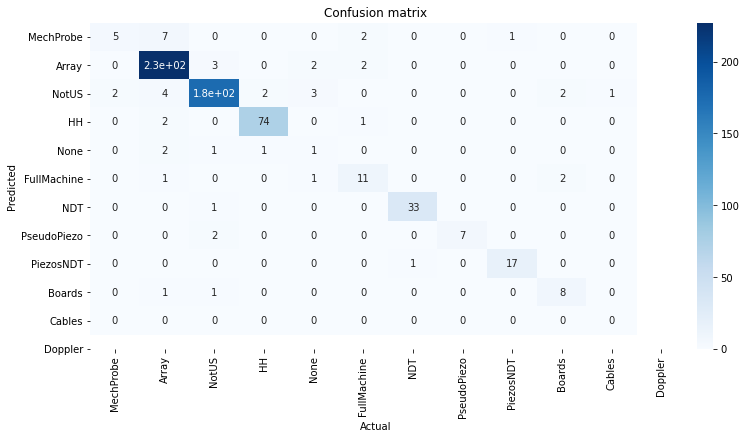

In [14]:
aux_df = df[['group', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, gbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['group'].values, 
            yticklabels=aux_df['group'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [15]:
base_model = GradientBoostingClassifier(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9141914191419142

In [16]:
best_gbc.fit(features_train, labels_train)
accuracy_score(labels_test, best_gbc.predict(features_test))

0.9207920792079208

In [17]:
d = {
     'Model': 'Gradient Boosting',
     'Training Set Accuracy': accuracy_score(labels_train, best_gbc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, gbc_pred)
}

df_models_gbc = pd.DataFrame(d, index=[0])

In [18]:
df_models_gbc

,Model,Training Set Accuracy,Test Set Accuracy
0,Gradient Boosting,0.980163,0.920792


In [19]:
with open('Models/best_gbc.pickle', 'wb') as output:
    pickle.dump(best_gbc, output)
    
with open('Models/df_models_gbc.pickle', 'wb') as output:
    pickle.dump(df_models_gbc, output)